# Exploring Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem import WordNetLemmatizer

## Let's analyze Resume.csv (CV dataset from Kaggle)

In [2]:
df = pd.read_csv('dataPandu.csv')
df

,description,job_title
0,ospf eigrp wireless networking vlan switching ...,data engineer
1,apply client exciting womenswear brand huge po...,graphic designer
2,node angularjs mysql bootstrap mongodb javascr...,software developer
3,apply exsurgo finance recruiting interim senio...,manager
4,apply ruby group recruiting permanent eastbour...,manager
...,...,...
42497,drupal manual testing debugging consulting per...,copywriter
42498,senior software engineer java swing senior sof...,software engineer
42499,apply company client extremely successful busi...,executive agency
42500,programmer analyst,data analyst


In [3]:
df['Description'] = df['description']
df.pop('description')
df

,job_title,Description
0,data engineer,ospf eigrp wireless networking vlan switching ...
1,graphic designer,apply client exciting womenswear brand huge po...
2,software developer,node angularjs mysql bootstrap mongodb javascr...
3,manager,apply exsurgo finance recruiting interim senio...
4,manager,apply ruby group recruiting permanent eastbour...
...,...,...
42497,copywriter,drupal manual testing debugging consulting per...
42498,software engineer,senior software engineer java swing senior sof...
42499,executive agency,apply company client extremely successful busi...
42500,data analyst,programmer analyst


In [4]:
df['job_title'].value_counts()

ios developer         9449
software engineer     9148
manager               1955
data analyst          1909
business analyst      1768
                      ... 
project management      33
digital marketing       31
database engineer       11
devops engineer          7
network engineer         5
Name: job_title, Length: 74, dtype: int64

In [5]:
jobs = np.sort(df['job_title'].unique()) #List of all categories array form
df_jobs = [df[df['job_title'] == job].loc[:, ['Description', 'job_title']] for job in jobs] #Create new df with interchanging cols
print(f'{len(jobs)} Jobs: ', jobs)

74 Jobs:  ['account executive' 'account manager' 'accountant' 'administrator'
 'advisor' 'analyst finance' 'android developer' 'angular js developer'
 'assistant manager' 'associate' 'associate manager' 'azure developer'
 'azure engineer' 'back end developer' 'business analyst'
 'business development' 'cloud engineer' 'consultant' 'copywriter'
 'customer service' 'cyber security' 'data analyst' 'data engineer'
 'data science' 'database engineer' 'developer' 'devops developer'
 'devops engineer' 'digital marketing' 'dotnet developer' 'engineer'
 'engineering' 'etl developer' 'executive agency' 'financial assistant'
 'front end developer' 'full stack developer' 'graphic designer' 'hiring'
 'ios developer' 'java developer' 'machine learning developer'
 'management specialist' 'manager' 'manager finance' 'marketing'
 'marketing executive' 'mobile developer' 'network engineer'
 'php developer' 'planner' 'platform engineer' 'product manager'
 'program manager' 'project management' 'project m

In [6]:
df_jobs[39]

,Description,job_title
7,support project quotation development activity...,ios developer
8,unix perl shell scripting automation python tr...,ios developer
22,candidate able interact deep learning research...,ios developer
23,professional attribute excellent written verba...,ios developer
25,transformation change management capability bu...,ios developer
...,...,...
42486,account payable general ledger,ios developer
42490,hand experience docker kubernetes helm etcshou...,ios developer
42492,bachelor degree electrical engineering equival...,ios developer
42494,key responsibility 1should good performance tu...,ios developer


## Let's see common words of each categories seen from word frequency

In [7]:
def wordfreq(data):
    count = data['Description'].str.split(expand=True).stack().value_counts().reset_index()
    count.columns = ['Word', 'Frequency']

    return count.head(10)

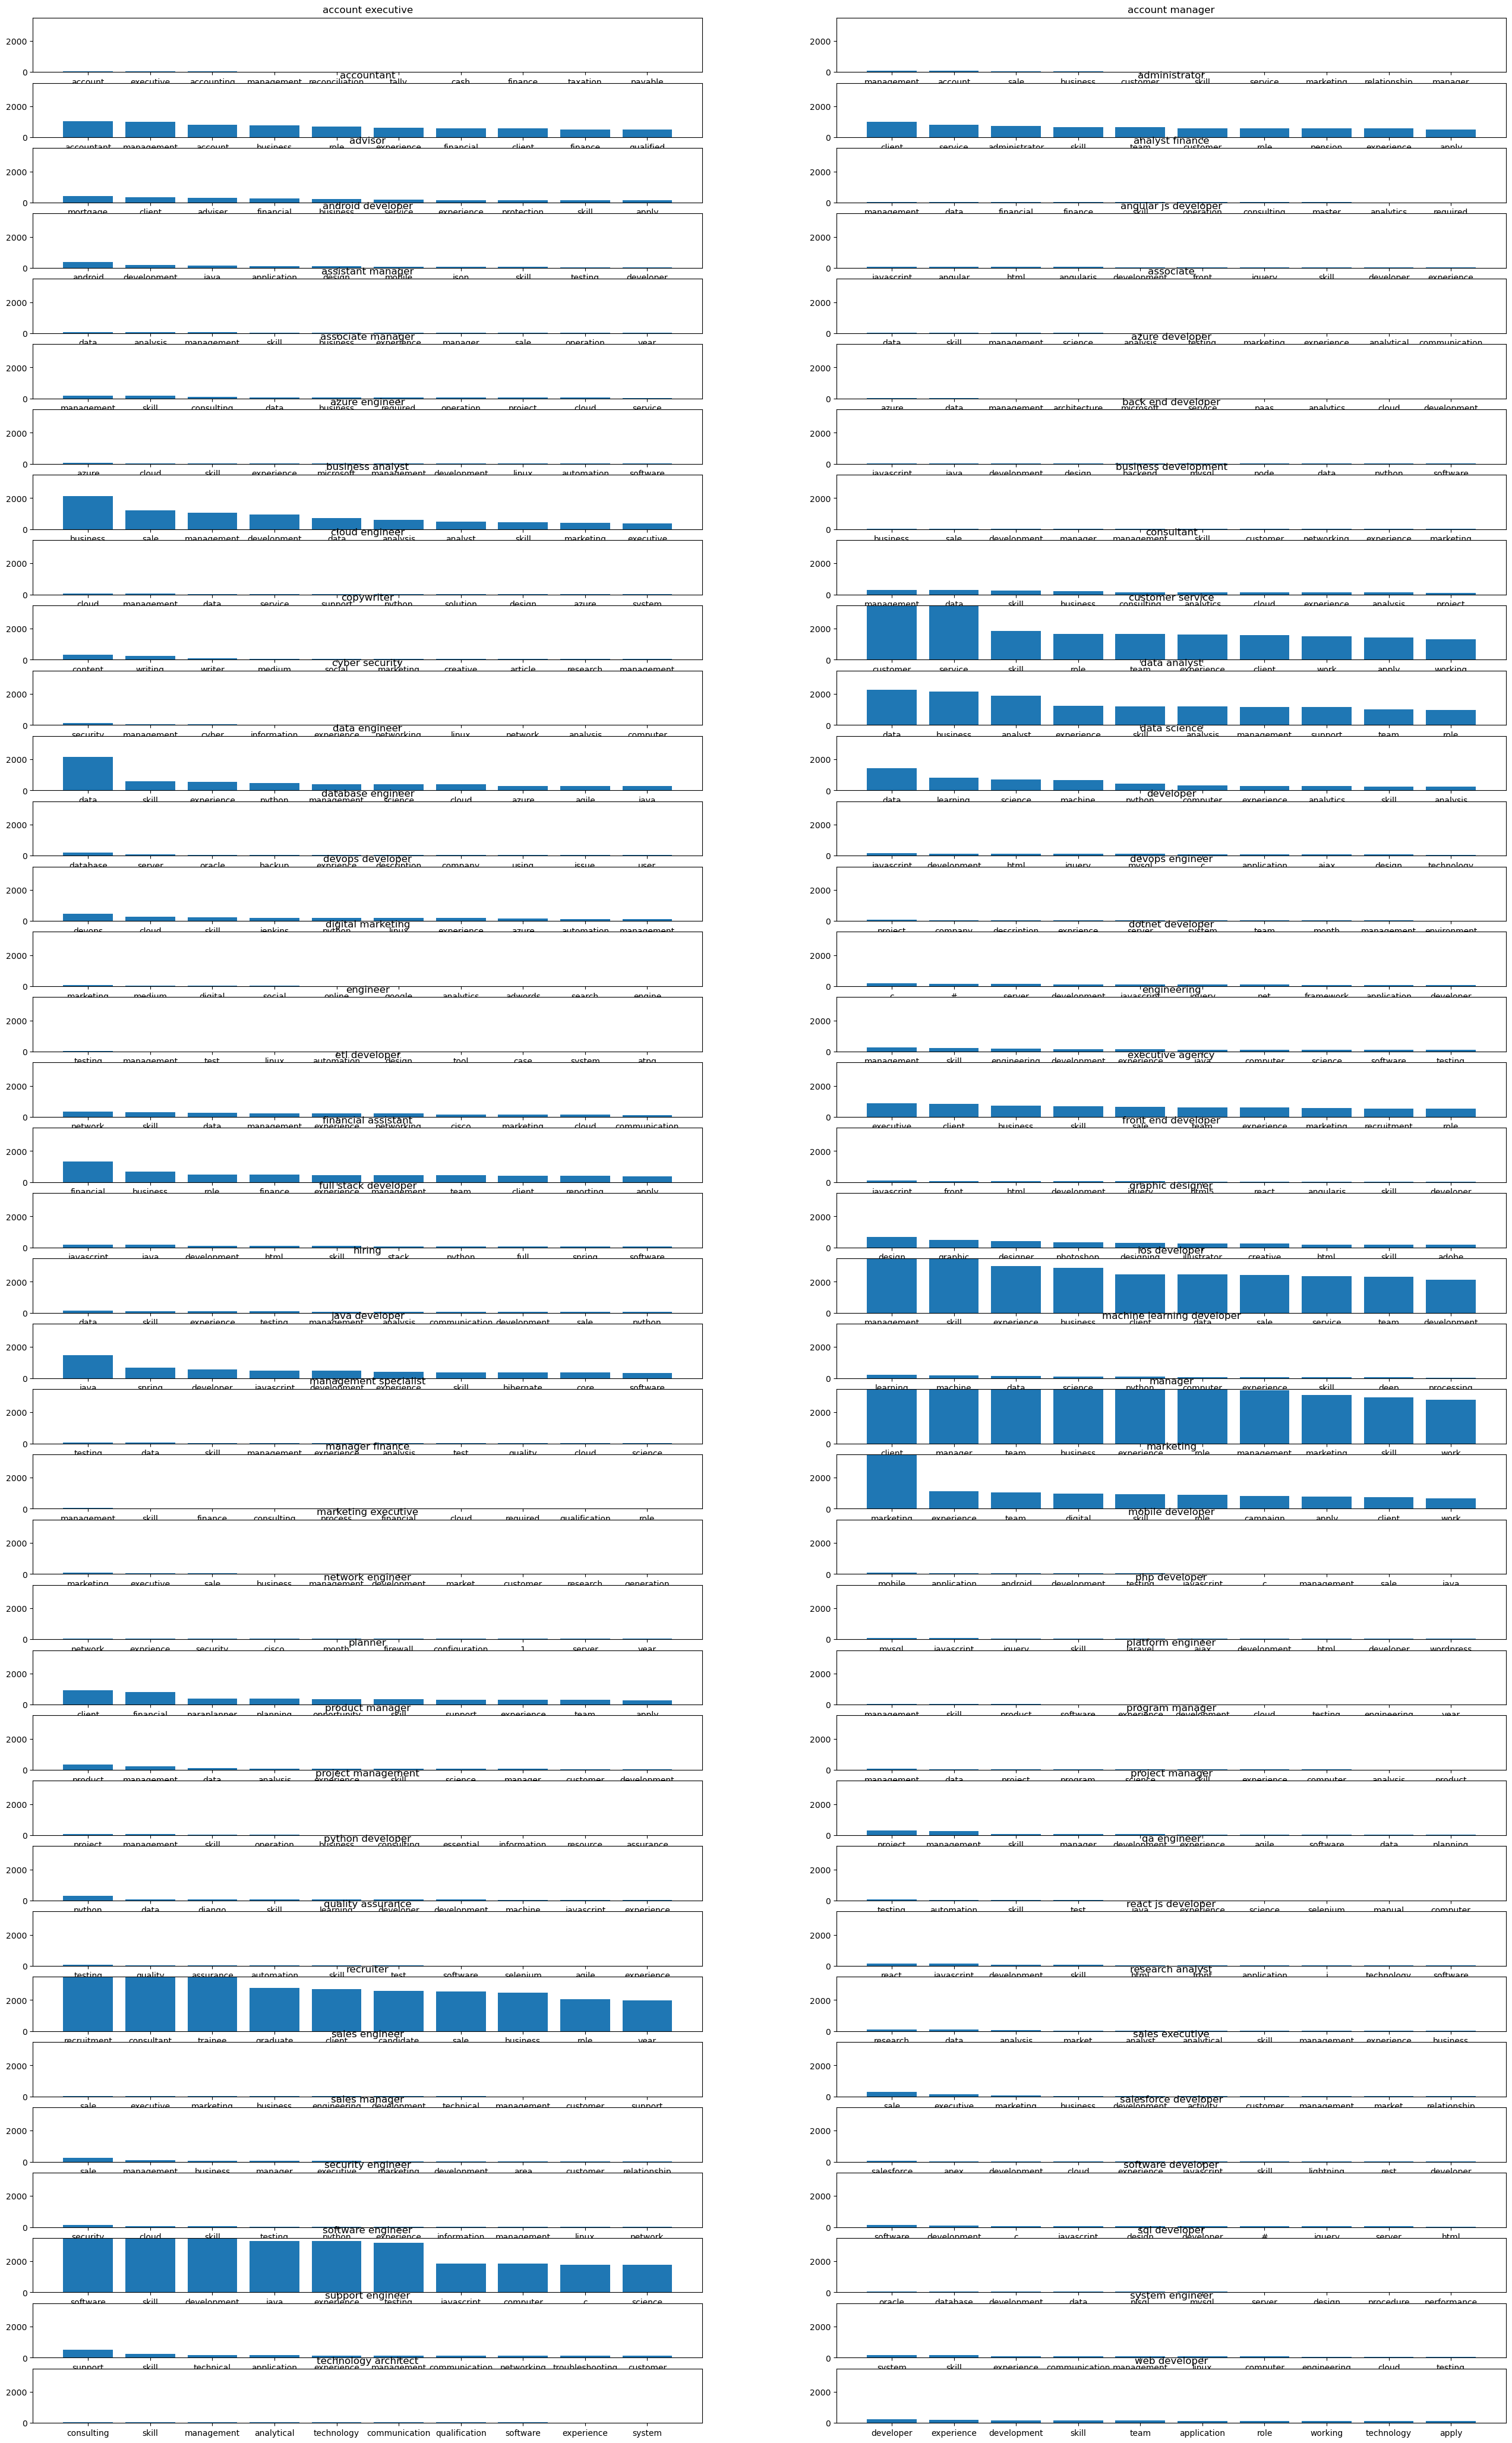

In [8]:
fig = plt.figure(figsize=(32, 64))

for i, job in enumerate(jobs):
    wf = wordfreq(df_jobs[i])

    fig.add_subplot(45, 2, i + 1).set_title(job)
    plt.bar(wf['Word'], wf['Frequency'])
    plt.ylim(0, 3500)

plt.show()
plt.close()

In [9]:
df.to_csv('CleanResume(dataPandu).csv', index=False)

# Bulding Model

In [10]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [11]:
with open("CleanResume(dataPandu).csv", encoding='utf8') as csvfile: #the csv file is not using the CP1252 encoding so I have to specify, 
                                                            #let's try to specify with the commonn encoding='utf8'
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

job_title,Description

Each data point looks like this:

data engineer,ospf eigrp wireless networking vlan switching routing l3



In [12]:
def parse_data_from_file(filename): # Extracts sentences and labels from a CSV file and returns sentences, labels
    sentences = []
    labels = []
    with open(filename, encoding='utf8') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[0])
            sentences.append(row[1])

    return sentences, labels

In [13]:
sentences, labels = parse_data_from_file("CleanResume(dataPandu).csv")

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words.\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}, the dataset has been shuffled!")

There are 42502 sentences in the dataset.

First sentence has 8 words.

There are 42502 labels in the dataset.

The first 5 labels are ['data engineer', 'graphic designer', 'software developer', 'manager', 'manager'], the dataset has been shuffled!


## Some variable for easy adjustement

In [14]:
MAXLEN = 600
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .9

## Let's split the lists of sentences and labels into training and validation

In [15]:
def train_val_split(sentences, labels, training_split):
    # Compute the number of sentences that will be used for training
    train_size = int(len(labels)*training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [17]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 38251 sentences for training.

There are 38251 labels for training.

There are 4251 sentences for validation.

There are 4251 labels for validation.


## Tokenize

In [18]:
def fit_tokenizer(train_sentences, oov_token):
    tokenizer = Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(train_sentences) # Fit the tokenizer to the training sentences

    return tokenizer

In [19]:
tokenizer = fit_tokenizer(train_sentences, OOV_TOKEN)
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words")
print("with <OOV> token included" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 48764 words
with <OOV> token included


In [20]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences) # Convert sentence to sequence
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding)
    
    return padded_sequences

In [21]:
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (38251, 600)
Padded validation sequences have shape: (4251, 600)


In [22]:
# Convert the labels into one-hot
train_label_seq = pd.get_dummies(train_labels)
val_label_seq = pd.get_dummies(val_labels)
val_label_seq

,account executive,account manager,accountant,administrator,advisor,analyst finance,android developer,angular js developer,assistant manager,associate,...,sales manager,salesforce developer,security engineer,software developer,software engineer,sql developer,support engineer,system engineer,technology architect,web developer
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4246,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4247,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4248,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4249,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Text classification model

### Model and learning rate tuning

In [23]:
EMBEDDING_DIM = 64
tf.random.set_seed(123)

In [24]:
model_tune = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBEDDING_DIM, input_length=MAXLEN, mask_zero=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(74, activation='softmax')])

In [25]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss='categorical_crossentropy', optimizer=optimizer)

history = model_tune.fit(train_padded_seq, train_label_seq, epochs=50, validation_data=(val_padded_seq, val_label_seq), callbacks=[lr_schedule])

Epoch 1/50
 223/1196 [====>.........................] - ETA: 24:36 - loss: 5.3590

KeyboardInterrupt: 

In [ ]:
# Define the learning rate array
lrs = 1e-4 * (10 ** (np.arange(50) / 10))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-4, 10, 0, 10])

### Build model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBEDDING_DIM, input_length=MAXLEN, mask_zero=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(80)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(80, activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(74, activation='softmax')])

model.compile(loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.SGD(learning_rate=2e-2, momentum=0.9),
            metrics=['accuracy'])

In [ ]:
history = model.fit(train_padded_seq, train_label_seq, epochs=20, validation_data=(val_padded_seq, val_label_seq))

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
import cv2
import pytesseract
from pytesseract import *

In [ ]:
pytesseract.tesseract_cmd = (r'C:\Users\KEVIN ASUS 516\AppData\Local\Programs\Tesseract-OCR\tesseract.exe')
img_pred = 'CV Raffli_page-0001.jpg'
img = cv2.imread(img_pred)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
threshold_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

In [ ]:
custom_config = r'--oem 3 --psm 6'

details = pytesseract.image_to_data(image=threshold_img,
                                    output_type=Output.DICT, 
                                    config=custom_config, 
                                    lang='eng')

In [ ]:
sample_text = ' '.join(teks_raw)
sample_text

In [ ]:
def predict_category(resume_text):
    preprocessed_text = preprocess(resume_text)
    
    resume_seq = tokenizer.texts_to_sequences([preprocessed_text]) # Convert sentence to sequence
    padded_resume = pad_sequences(resume_seq, maxlen=MAXLEN, padding=PADDING)
    
    predicted_probabilities = model.predict(padded_resume)
    predicted_category = np.argmax(predicted_probabilities)
    
    predicted_label = categories[predicted_category]
    
    return predicted_label

In [ ]:
prediction = predict_category(sample_text)
print(prediction)

In [ ]:
# model.save("ModelCV.h5")